# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

In [2]:
df = pd.read_csv('../data/reviews_Model.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,neu_score,pos_score,compound_score,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.707,0.293,0.4404,9,3,20,26,47,8,Good Seller Service
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.408,0.592,0.4404,9,3,20,13,19,3,Good Overall Service
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase,first happy,purchase experience purchase,NaN,NaN,...,0.714,0.286,0.3400,9,3,20,11,57,7,Good Seller Service
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.715,0.285,0.4927,9,3,20,8,35,9,Good Overall Service
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,1.000,0.000,0.0000,9,3,19,37,16,3,Good Overall Service


## Taking out all bad reviews for training

In [4]:
df[df['rating'] <= 3 ]['category'].value_counts(normalize = True)

App Issues              0.563413
Bad Customer Service    0.369820
Bad Seller Reviews      0.066768
Name: category, dtype: float64

In [5]:
df = df[df['rating'] <= 3 ][['category', 'clean_content', 'review']]
df.head()

,category,clean_content,review
11,App Issues,stupid bubble game impossible tap bubble chang...,Stupid shoppee bubble game. Impossible. When t...
40,App Issues,recent update shoppe bubble game unplayable li...,Recent update make shoppe bubble game unplayab...
69,Bad Customer Service,d come contact live chat rep purposely waste t...,Was quite ok with d app until I came into cont...
122,App Issues,aware manage beat claim certain voucher able u...,Be aware that even though you managed to beat ...
139,Bad Customer Service,delete account receive defective item seller g...,Deleted the app and my account. Received sever...


In [6]:
#Checking null values
df.isna().sum()

category         0
clean_content    0
review           0
dtype: int64

## Train Test Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['category'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['category'])

In [8]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 12161, X_test rows: 3041
y_train rows: 12161, y_test rows: 3041


## Baseline Model

In [9]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(12161, 5000)
(3041, 5000)


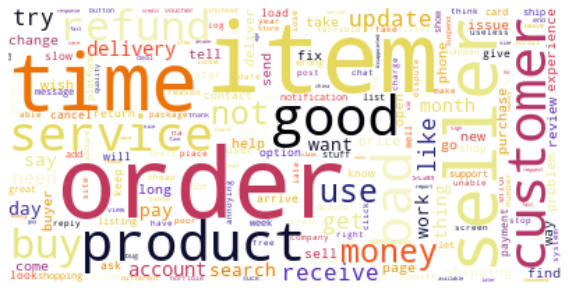

In [10]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9791135597401529
Accuracy score for Test data set: 0.9187767181848077


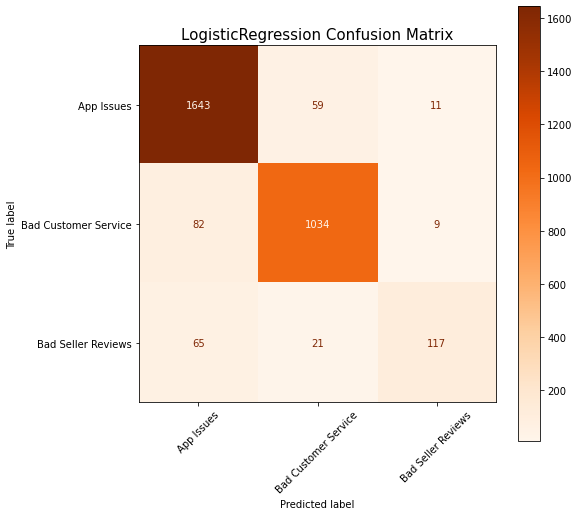

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(lr, test_data_features, y_test, ax = ax, cmap='Oranges', xticks_rotation=45);

In [13]:
print(classification_report(y_test, lr.predict(test_data_features), digits=3))

                      precision    recall  f1-score   support

          App Issues      0.918     0.959     0.938      1713
Bad Customer Service      0.928     0.919     0.924      1125
  Bad Seller Reviews      0.854     0.576     0.688       203

            accuracy                          0.919      3041
           macro avg      0.900     0.818     0.850      3041
        weighted avg      0.917     0.919     0.916      3041



## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [14]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [7000, 8000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = RandomizedSearchCV(cvec_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  82.301s


### TFIDVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.3min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  76.587s


### HashingVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = RandomizedSearchCV(hash_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\Sim Yi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   32.9s finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=6000)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  34.455s


In [17]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.902078,0.910550,0.839439,82
1,LogisticRegression,TFIDVectorizer,0.909183,0.919531,0.857130,77
2,LogisticRegression,HashingVectorizer,0.899143,0.905724,0.825083,34


In [18]:
print(classification_report(y_test, gs_tfid_lr.predict(X_test), digits=3))

                      precision    recall  f1-score   support

          App Issues      0.929     0.958     0.943      1713
Bad Customer Service      0.913     0.946     0.929      1125
  Bad Seller Reviews      0.954     0.512     0.667       203

            accuracy                          0.924      3041
           macro avg      0.932     0.805     0.846      3041
        weighted avg      0.925     0.924     0.920      3041



## Trying with Different Models

### Logistic Regression

In [19]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(0, 10, 11))
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])
Fit time:  96.079s


### MultinomialNB

In [20]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0,1,11))
}

gs_tfid_nb = RandomizedSearchCV(tfid_nb, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 40,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   52.7s finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.1))])
Fit time:  54.000s


### SGDClassifier

In [21]:
# Setting pipeline for two stages
tfid_clf = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('clf', SGDClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    
    
}

gs_tfid_clf = RandomizedSearchCV(tfid_clf, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_clf.fit(X_train, y_train)
tfid_clf_test_time = time() - t0
print(f'Best SGDClassifier Parameters: {gs_tfid_clf.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_clf_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.3s finished


Best SGDClassifier Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('clf', SGDClassifier(penalty='elasticnet'))])
Fit time:  52.326s


### RandomForest

In [22]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('rf', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [8, 15, 25],
    'rf__min_samples_split': [5, 15, 100],
    'rf__max_leaf_nodes': [10, None]
}

gs_tfid_ran = RandomizedSearchCV(tfid_ran, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=42))])
Fit time:  139.651s


### Adaboost

In [23]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = RandomizedSearchCV(tfid_ada, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 40,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.2min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=5)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.6499999999999999,
                                    n_estimators=200))])
Fit time:  320.432s


### Accuracy & F1 Macro Score

In [24]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])


summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SGDClassifier', 'TFIDVectorizer', 
                gs_tfid_clf.best_score_,
                gs_tfid_clf.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_clf.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_clf.predict(X_test)),
                round(tfid_clf_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'Kappa_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,Kappa_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.917347,0.929487,0.872963,0.872263,96
1,MultinomialNB,TFIDVectorizer,0.893891,0.900156,0.821783,0.819978,54
2,SGDClassifier,TFIDVectorizer,0.910768,0.914254,0.847745,0.846297,52
3,RandomForest,TFIDVectorizer,0.796038,0.799810,0.661848,0.655206,140
4,Adaboost,TFIDVectorizer,0.844081,0.844560,0.717113,0.715356,320


# Gridsearch best model

In [25]:
# Setting pipeline for two stages
best_m = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(12, 16, 5))
}

gs_best_m = GridSearchCV(best_m, # what object are we optimizing?
                         param_grid =pipe_params, # what parameters values are we searching?
                         cv=3, verbose = 1, n_jobs = -1, scoring = 'f1_weighted') # 5-fold cross-validation.
t0 = time()
gs_best_m.fit(X_train, y_train)
best_m_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_best_m.best_estimator_}')
print('Fit time:  %0.3fs' % best_m_test_time);

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 18.0min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=15, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=13.0, max_iter=5000))])
Fit time:  1084.486s


In [26]:
summary = []

summary.append(['Before', 'LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                cohen_kappa_score(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])

summary.append(['After', 'LogisticRegression', 'TFIDVectorizer', 
                gs_best_m.best_score_,
                gs_best_m.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_best_m.predict(X_test)),
                cohen_kappa_score(y_test, gs_best_m.predict(X_test)),
                round(best_m_test_time)])

pd.DataFrame(summary, 
             columns = ['state',
                        'model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'Kappa_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,state,model,vectorizer,train_score,test_score,MCC_score,Kappa_score,time(s)
0,Before,LogisticRegression,TFIDVectorizer,0.917347,0.929487,0.872963,0.872263,96
1,After,LogisticRegression,TFIDVectorizer,0.916452,0.931363,0.875673,0.875237,1084


## Confusion Matrix

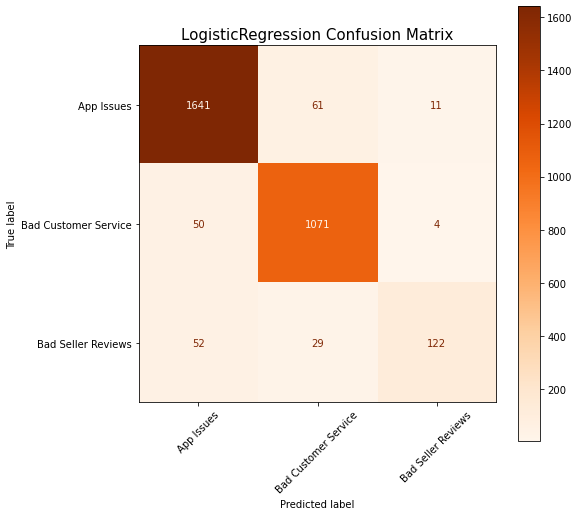

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges', xticks_rotation=45);

## Checking Misclassified Post

In [28]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test

# Check out first five rows.
results.head()

,predicted,actual
17450,App Issues,App Issues
50209,App Issues,App Issues
19195,Bad Customer Service,Bad Customer Service
14736,Bad Customer Service,Bad Customer Service
66826,App Issues,App Issues


In [29]:
# Find all indices where predicted and true results 
# aren't the same, then save in an array.
row_ids = results[results['predicted']!= results['actual']].index
row_ids

Int64Index([71566, 43913, 39441, 51594, 60714, 72583, 43508, 13566, 31506,
            29116,
            ...
            51668, 45332, 39050, 47248,  5872, 74509, 47548, 50874, 73785,
            45745],
           dtype='int64', length=207)

In [30]:
i = 1
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual category: {y_test[row_ids[i]]}')
print('Predicted category: '+ results['predicted'][row_ids[i]])

Post ID: 43913
----
Pothik view says that Amazon was an amazing company but with shame and regret is now not worthy enough...
----
Actual category: Bad Customer Service
Predicted category: App Issues


In [31]:
i = 2
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual category: {y_test[row_ids[i]]}')
print('Predicted category: '+ results['predicted'][row_ids[i]])

Post ID: 39441
----
I'll be moving my stuff to Etsy after finding out ebay funded socialism and the Biden campaign.
----
Actual category: Bad Customer Service
Predicted category: App Issues


In [32]:
i = 3
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual category: {y_test[row_ids[i]]}')
print('Predicted category: '+ results['predicted'][row_ids[i]])

Post ID: 51594
----
Very confusion
----
Actual category: Bad Seller Reviews
Predicted category: Bad Customer Service


In [33]:
i = 7
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual category: {y_test[row_ids[i]]}')
print('Predicted category: '+ results['predicted'][row_ids[i]])

Post ID: 13566
----
Once done give feedback to buyer/seller, can't re-edit (do correction) back the rating & feedback details after publish, hope carousell team allow it (example: limit 1 time only to edit/ revert feedback and rating) to reduce rating mistake made by user. Finally, request a "Dark mode" feature inside the setting.
----
Actual category: Bad Seller Reviews
Predicted category: App Issues


## Train data on whole dataset

In [34]:
best_model = gs_best_m.best_estimator_
best_model

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [35]:
best_model.fit(df['clean_content'], df['category'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=8000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=4.0, max_iter=5000))])

In [36]:
filename = 'Best_Model_BadReview_P2.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))